# Planification d'une tournée musicale

Dans ce sujet de SAE, sur 2 séances encadrées, nous allons utiliser la formalisation d'un problème de résolution par l'exploration ainsi que les différents algorithmes de recherche vus en cours puis en TD pour traiter un problème d'organisation d'une tournée française d'un groupe de musique sous la forme d'un problème de voyageur de commerce.

Dans le début de ce notebook, l'implémentation de la formalisation générique d'un problème de résolution par l'exploration ainsi que les différents algorithmes de recherche vus en cours puis en TD vous sont fournis. Vous aurez ensuite à compléter la classe `PlanificationTournee` pour résoudre ce problème sur des données qui vous sont fournies. Vous pourrez ensuite ajouter de nouvelles villes, en faisant appel à l'API Python d'Open Street Map, pour récupérer les distances avec vos nouvelles villes.

# Noms
- *Lénny Barassin*
- *Victor Benêteau*
- *Ewen Bosquet*
- *Jonathan Boulay*

In [1]:
#from numpy.random import randint
import matplotlib.pyplot as plt
#import random
import heapq
import math
#import sys
from collections import defaultdict, deque, Counter
#from itertools import combinations

#%pip install geopy
from geopy.distance import great_circle as GRC
#%pip install geopandas
import geopandas as gpd
import pandas as pd
#%pip install contextily
import contextily as ctx
import shapely.geometry
from matplotlib.colors import to_hex
%pip install seaborn
import seaborn as sns

     |████████████████████████████████| 293 kB 3.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Définition d'un problème

On commence par définir une classe abstraite pour représenter un `Problem` qui sera résolu par l'exploration.

On indique l'état initial et soit l'état final (s'il y en a un seul), soit la manière de savoir si on se trouve dans un état final (en redéfinissant la méthode `is_goal`, dans la sous-classe qui implémente la classe `Problem`). La sous-classe devra également implémenter le constructeur `__init__`(en ajoutant éventuellement d'autres paramètres) et les méthodes `actions`, `result` `action_cost` et `h`. 


In [2]:
class Problem:
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other arguments for the subclass."""

    def __init__(self, initial=None, goal=None): 
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal
        
        
    def actions(self, state):     
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""   
        raise NotImplementedError
    
    def result(self, state, action): 
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError
    
    
    def is_goal(self, state):   
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor."""     
        return state == self.goal
    
    
    def action_cost(self, s, a, s1): 
        """Return the cost of an action a from state s to state s1."""
        return 1
    
    
    def h(self, node):  
        """Returns least possible cost to reach a goal for the state in given node."""             
        return 0
    
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

# Définition d'un noeud

Dans la classe `Node`, on définit un noeud dans un arbre de recherche.
Le noeud contient un pointeur vers son noeud parent `parent` ainsi que vers l'état `state` auquel il correspond (la notion d'état sera défini au moment de la définition du problème représenté). Il est à noter que si un état peut être atteint par 2 chemins, il y aura alors 2 noeuds contenant le même état. Le noeud contient également l'action `action` qui a permis d'atteindre l'état associé au noeud ainsi que le coût total `path_cost` du chemin allant du noeud initial au noeud courant (correspondant à la valeur g dans les algorithmes d'exploration).

In [3]:
class Node:
    "A Node in a search tree."
    
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost


    def __repr__(self): 
        return '<{}>'.format(self.state)
    
    
    def __len__(self): 
        return 0 if self.parent is None else (1 + len(self.parent))
    
    
    def __lt__(self, other): 
        return self.path_cost < other.path_cost
    

## Fonctions relatives aux noeuds d'un arbre de recherche

On définit également quelques fonctions sur les noeuds : `expand` pour générer les noeuds successeurs d'un noeud donné, `path_actions` pour récupérer la liste d'actions ayant permis d'arriver jusqu'au noeud et `path_states` pour récupérer la liste des états ayant permis d'arriver jusqu'au noeud.


In [4]:
def expand(problem, node):
    "Expand a node, generating the children nodes (see slide 18 in the lecture)."
    s = node.state
    succs = []
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        succs.append(Node(s1, node, action, cost))
    return succs
        

def path_actions(node):
    "The list of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The list of states to get to this node."
    #if node in (failure, None): 
    if node.parent is None:
        return [node.state]
    return path_states(node.parent) + [node.state]

# Différents types de files pour implémenter la frontière

Les files FIFO et LIFO sont utilisées, respectivement, pour implémenter la `frontière` dans l'exploration en largeur et dans l'exploration en profondeur. La file de priorié `PriorityQueue` est utilisée dans l'exploration gloutonne et dans l'exploration A* pour garder la frontière triée en fonction du score croissant `f(item)`.

In [5]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queue."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): 
        return self.items[0][1]

    def __len__(self): 
        return len(self.items)


# Algorithmes de recherche

Les algorithmes de recherche non-informée (exploration en largeur et exploration en profondeur, en mémorisant ou non les états déjà exploras) ainsi que les algorithmes de recherche informée (exploration gloutonne et A*) seront implémentés ici.

In [6]:
# Noeud particulier pour indiquer qu'un algorithme ne peut pas trouver de solution    
failure = Node('failure', path_cost=math.inf)

## Exploration en largeur de l'arbre de recherche


In [7]:
def breadth_first_tree_search(problem: Problem):
    """Search the shallowest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Repeats infinitely in case of loops."""
    frontier = FIFOQueue([Node(problem.initial)])  # FIFO queue

    while frontier:
        node = frontier.popleft()
        #print(node)
        if problem.is_goal(node.state):
            return node
        frontier.extend(expand(problem, node))
    return None

## Exploration en largeur du graphe des états


In [8]:
def breadth_first_graph_search(problem: Problem):
    """Search the shallowest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Does not get trapped by loops.
    If two paths reach a state, only use the first one.
    """
    node = Node(problem.initial)
    if problem.is_goal(node.state):
        return node
    frontier = FIFOQueue([node])
    explored = set()
    while frontier:
        node = frontier.popleft()
        if problem.is_goal(node.state):
            return node
        explored.add(node.state)
        for child in expand(problem, node):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
    return None

## Exploration en profondeur de l'arbre de recherche


In [9]:
def depth_first_tree_search(problem: Problem):
    """Search the deepest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Repeats infinitely in case of loops.
    """
    frontier = LIFOQueue([Node(problem.initial)])  # Stack

    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        frontier.extend(expand(problem, node))
    return None

## Exploration en profondeur du graphe des états

In [10]:
def depth_first_graph_search(problem: Problem):
    """Search the deepest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Does not get trapped by loops.
    If two paths reach a state, only use the first one.
    """
    frontier = LIFOQueue([(Node(problem.initial))])  # Stack

    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        explored.add(node.state)
        frontier.extend(child for child in expand(problem, node)
                        if child.state not in explored and child not in frontier)
    return None

## Exploration gloutonne du graphe des états


In [11]:
def greedy_graph_search(problem: Problem, h=None):
    """Search nodes with minimum h(n)."""
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=h)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

## Exploration A* du graphe des états


In [12]:
def astar_graph_search(problem: Problem, f=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

# Définition d'une carte

On commence par définir la classe `Map` (pour représenter les villes d'une carte). 
Une carte contient les coordonnées gps des villes considérées (correspondant à l'attribut `coords`) ainsi que les distances réelles (c'est-à-dire en ne passant que par des routes existantes) entre certains couples de villes (correspondant à l'attribut `distances`, représenté par un dictionnaire dont la clé est une paire de noms de villes ; chaque ville est désignée par son nom). Le graphe considéré n'est donc pas toujours un graphe complet (on ne donne pas les distances réelles entre tous les couples de villes qu'on pourrait former). 


#### Question 1 : compléter la méthode `neighbors(city)` et la fonction `neighbors_not_visited(map, state)`.

In [13]:
class Map:
    
    def __init__(self, distances=None, locations=None):
        '''Constructeur avec un dictionnaire de distances réelles entre paires de villes 
        et un dictionnaire de coordonnées gps pour chaque ville'''
        self.distances: dict[tuple[str, str], float]= distances
        self.locations: list[str] = locations
        
    
    def distance(self, city1: str, city2: str) -> float:
        ''' Retourne la distance réelle entre les villes city1 et city2'''
        return self.distances[(city1, city2)]


    def location(self, city):
        ''' Retourne les coordonnées de la ville city sous la forme (longitude, latitude)'''
        return self.locations[city]
    
    
    def nb_cities_map(self):
        ''' Retourne le nombre de villes différentes de la carte'''
        return len(self.locations)
    
    
    def is_neighbor(self, city, city1):
        '''Retourne vrai si city1 est une ville voisine de city, c'est-à-dire s'il existe
        une route (et donc une distance réelle) entre city et city1'''
        return (city, city1) in self.distances
    

    def neighbors(self, city):
        ''' Retourne les villes voisines de city, c'est-à-dire accessibles directement par une route'''
        return [city1 for city1 in self.locations if self.is_neighbor(city, city1)]
    
# autres fonctions
def cities_state(state):
    '''Retourne la liste des villes contenues dans l'état state'''
    return state.split(" ; ")
    

def neighbors_not_visited(map, state):
    """Retourne la liste des villes voisines de la dernière ville atteinte dans l'état state 
    mais qui n'ont pas déjà été visitées dans l'état state.
    """
    return [i for i in map.neighbors(cities_state(state)[-1]) if i not in cities_state(state)]

## Test de la classe Map

In [14]:
# Une première carte avec 10 villes
tour1 = Map(
    {('Caen', 'Rennes'): 185, ('Caen', 'Nantes'): 271, ('Caen', 'Le Mans'): 160,
     ('Rennes', 'Caen'): 184, ('Rennes', 'Le Mans'): 157, ('Rennes', 'Nantes'): 123,
     ('Le Mans', 'Caen'): 165, ('Le Mans', 'Rennes'): 162, ('Le Mans', 'Angers'): 90, ('Le Mans', 'Orléans'): 137,
     ('Orléans', 'Le Mans'): 138, ('Orléans', 'Angers'): 221, ('Orléans', 'Clermont-Ferrand'): 301,
     ('Angers', 'Le Mans'): 98, ('Angers', 'Nantes'): 92, ('Angers', 'Orléans'): 221, ('Angers', 'Clermont-Ferrand'): 405,
     ('Nantes', 'Le Mans'): 177, ('Nantes', 'Angers'): 93, ('Nantes', 'Caen'): 274, ('Nantes', 'Rennes'): 122, ('Nantes', 'Clermont-Ferrand'): 468,
     ('La Rochelle', 'Nantes'): 148, ('La Rochelle', 'Bordeaux'): 199, ('La Rochelle', 'Clermont-Ferrand'): 391,
     ('Bordeaux', 'La Rochelle'): 202, ('Bordeaux', 'Toulouse'): 249, ('Bordeaux', 'Clermont-Ferrand'): 371,
     ('Toulouse', 'Bordeaux'): 246, ('Toulouse', 'Clermont-Ferrand'): 368,
     ('Clermont-Ferrand', 'Toulouse'): 367, ('Clermont-Ferrand', 'Bordeaux'): 372, ('Clermont-Ferrand', 'La Rochelle'): 393,
     ('Clermont-Ferrand', 'Nantes'): 450, ('Clermont-Ferrand', 'Angers'): 400, ('Clermont-Ferrand', 'Orléans'): 301
     },
    {'Nantes': (47.21, -1.56), 'Angers': (47.49, -0.54), 
     'Orléans': (47.90, 1.89), 'Rennes': (48.10, -1.71), 
     'La Rochelle': (46.16, -1.22), 'Caen': (49.21, -0.34), 
     'Le Mans': (47.96, 0.20), 'Bordeaux': (44.86, -0.52), 
     'Toulouse': (43.57, 1.32), 'Clermont-Ferrand': (45.79, 3.10)
     })

node1 = Node("Nantes")
node2 = Node("Le Mans ; Nantes")
node3 = Node("Le Mans ; Angers ; Nantes")


# test de la méthode neighbors
print("\nTest de la méthode neighbors()")
print("Villes voisines de Nantes : " + str(tour1.neighbors('Nantes')))
print("Villes voisines de Toulouse : " + str(tour1.neighbors('Toulouse')))


# calcul de la distance "à vol d'oiseau" entre 2 villes, en utilisant la module geodesic
print("\nTest du calcul de distances avec geopy")
nantes = (47.21, -1.56)
rennes = (48.10, -1.71)
angers = (47.49, -0.54)
print("La distance entre Nantes et Rennes est : ", GRC(nantes, rennes).km)
print("La distance entre Nantes et Angers est : ", GRC(nantes, angers).km)


# test de la fonction neighbors_not_visited
print("\nTest de la fonction neighbors_not_visited()")
print('voisins non visités de "', node1.state, '" : ', neighbors_not_visited(tour1, node1.state))
print('voisins non visités de "', node2.state, '" : ', neighbors_not_visited(tour1, node2.state))
print('voisins non visités de "', node3.state, '" : ', neighbors_not_visited(tour1, node3.state))



Test de la méthode neighbors()
Villes voisines de Nantes : ['Angers', 'Rennes', 'Caen', 'Le Mans', 'Clermont-Ferrand']
Villes voisines de Toulouse : ['Bordeaux', 'Clermont-Ferrand']

Test du calcul de distances avec geopy
La distance entre Nantes et Rennes est :  99.59926360928667
La distance entre Nantes et Angers est :  82.91041688605041

Test de la fonction neighbors_not_visited()
voisins non visités de " Nantes " :  ['Angers', 'Rennes', 'Caen', 'Le Mans', 'Clermont-Ferrand']
voisins non visités de " Le Mans ; Nantes " :  ['Angers', 'Rennes', 'Caen', 'Clermont-Ferrand']
voisins non visités de " Le Mans ; Angers ; Nantes " :  ['Rennes', 'Caen', 'Clermont-Ferrand']


# Planification d'une tournée musicale

Pour résoudre le problème de planification d'une tournée musicale, on définit la classe `MusicTourProblem`. La résolution de ce problème consiste à partir d'une ville de départ et à parcourir toutes les autres villes données, une et une seule fois, **puis revenir dans la ville de départ**, en minimisant le trajet total.

Un état est représenté par une chaîne de caractères et contient la séquence des noms complets des villes déjà parcourues, séparées par des point-virgules (par exemple, `'Nantes ; Rennes ; Angers'`). 

Les actions sont également des chaînes de caractères et chaque action correspond au nom complet d'une ville ; par exemple, l'action `'Nantes'` correspond à l'action de se déplacer dans la ville de `'Nantes'`. 

Les liaisons possibles entre les villes sont données grâce à l'objet de type `Map`, qui correspond à un graphe orienté, dans lequel les sommets sont les villes (avec leurs coordonnées gps) et les arcs sont les routes existantes entre 2 villes (avec la distance entre les villes).

L'heuristique utilisée correspond à la "distance à vol d'oiseau" minimale entre la dernière ville parcourue et les villes non encore parcourues (utilisez la fonction `great_circle` de `geopy.distance`). S'il ne reste plus de villes non encore parcourues, l'heuristique vaudra 0. 

#### Question 2 : compléter la classe `MusicTourProblem`.

In [15]:
class MusicTourProblem(Problem):
    
    def __init__(self, initial=None, goal=None, map=None):
        '''Constructeur de la classe avec une carte comme attribut (en plus de l'état intial)'''
        super().__init__(initial, goal)
        self.map = map
    
    
    def actions(self, state): 
        '''Retourne la liste des actions possibles à partir de l'état state, 
        c'est-à-dire la liste des villes voisines non encore explorées dans l'état 
        (en autorisant de revenir dans la ville de départ si on a exploré toutes les villes)'''
        cities = cities_state(state)
        neighbors = self.map.neighbors(cities[-1])
        if set(cities) == set(self.map.locations) and cities[0] in neighbors:
            return [cities[0]]
        if not neighbors:
            return failure
        return neighbors_not_visited(self.map, state)
    
    
    def result(self, state, action):
        '''Retourne l'état obtenu en effectuant l'action choisie à partir de state,
        c'est-à-dire on concatène la ville correspondant à l'action à la fin de state'''
        return state + " ; " + action
    
    
    def is_goal(self, state):   
        '''L'état state est un état final s'il contient toutes les villes de la carte
        et que la dernière ville de l'état est aussi celle de départ (la ville de départ
        est donc présente 2 fois)'''
        cities = cities_state(state)
        return set(cities) == set(self.map.locations) and cities[0] == cities[-1]
    
    
    def action_cost(self, s, action, s1):
        '''Le coût de l'action pour aller de l'état s à l'état s1 correspond à la distance réelle
        entre la dernière ville de l'état s et la dernière ville de l'état s1'''
        return self.map.distance(cities_state(s)[-1], cities_state(s1)[-1])
    
    
    def h(self, node):
        '''Distance à vol d'oiseau minimum entre la dernière ville visitée de l'état de node
        et les villes non encore visitées'''
        cities = cities_state(node.state)
        try:
            return min([GRC(self.map.locations[cities[-1]], self.map.locations[city]).km for city in self.map.locations if city in self.actions(node.state)])
        except ValueError:
            return 0
    
     
# autres fonctions

def g(n): 
    return n.path_cost

### Test des méthodes de la classe `MusicTourProblem`

In [16]:
# création de la tournée musicale 1
music1 = MusicTourProblem(initial="Nantes", map=tour1)

node1 = Node("Nantes")
node2 = Node("Nantes ; Le Mans ; Nantes")
node3 = Node("Nantes ; Le Mans ; Angers ; Nantes")
node4 = Node("Nantes ; Le Mans ; Angers ; Nantes ; Rennes")
node5 = Node("Nantes ; Angers ; Le Mans ; Rennes ; Caen ; Orléans ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle")
nodeFin = Node("Nantes ; Angers ; Le Mans ; Rennes ; Caen ; Orléans ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle ; Nantes")


# test des méthodes de la classe MusicTourProblem
print("\nTest de la méthode actions()")
print("actions possibles à partir de ", node1, " : ", music1.actions(node1.state))
print("actions possibles à partir de ", node3, " : ", music1.actions(node3.state))
print("actions possibles à partir de ", node4, " : ", music1.actions(node4.state))
print("actions possibles à partir de ", node5, " : ", music1.actions(node5.state))
print("actions possibles à partir de ", nodeFin, " : ", music1.actions(nodeFin.state))

print("\nTest de la méthode result()")
print('état résultat obtenu à partir de "', node1.state, '" et "Rennes" : "', music1.result(node1.state, 'Rennes'), '"')
print('état résultat obtenu à partir de "', node5.state, '" et "Nantes" : "', music1.result(node5.state, 'Nantes'), '"')

print("\nTest de la méthode is_goal()")
print(str(node3), " noeud final ? ", music1.is_goal(node3.state))
print(str(nodeFin), " noeud final ? ", music1.is_goal(nodeFin.state))

print("\nTest de la méthode action_cost()")
print("coût de l'action entre ", node3, " et ", node4, " : ", music1.action_cost(node3.state, 'Rennes', node4.state))

print("\nTest de la méthode h()")
print('heuristique pour ', node1, ' : ', music1.h(node1))# correspond à la distance à vol d'oiseau entre Nantes et Angers
print('heuristique pour ', node3, ' : ', music1.h(node3))# correspond à la distance à vol d'oiseau entre Nantes et Rennes



Test de la méthode actions()
actions possibles à partir de  <Nantes>  :  ['Angers', 'Rennes', 'Caen', 'Le Mans', 'Clermont-Ferrand']
actions possibles à partir de  <Nantes ; Le Mans ; Angers ; Nantes>  :  ['Rennes', 'Caen', 'Clermont-Ferrand']
actions possibles à partir de  <Nantes ; Le Mans ; Angers ; Nantes ; Rennes>  :  ['Caen']
actions possibles à partir de  <Nantes ; Angers ; Le Mans ; Rennes ; Caen ; Orléans ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle>  :  ['Nantes']
actions possibles à partir de  <Nantes ; Angers ; Le Mans ; Rennes ; Caen ; Orléans ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle ; Nantes>  :  []

Test de la méthode result()
état résultat obtenu à partir de " Nantes " et "Rennes" : " Nantes ; Rennes "
état résultat obtenu à partir de " Nantes ; Angers ; Le Mans ; Rennes ; Caen ; Orléans ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle " et "Nantes" : " Nantes ; Angers ; Le Mans ; Rennes ; Caen ; Orléans ; Clermont-Ferrand ; Toulouse ; Bor

### Question 3 : tester les différents algorithmes de recherche non informés et informés, en affichant le chemin obtenu et la distance totale sur ce chemin.

In [17]:
# test des algorithmes de recherche sur la carte tour1
music1 = MusicTourProblem(initial='Nantes', map=tour1)
chemin_prof = depth_first_graph_search(music1)
chemin_largeur = breadth_first_graph_search(music1)
chemin_glouton = greedy_graph_search(music1, music1.h)
chemin_a = astar_graph_search(music1, lambda n: music1.h(n) + g(n))
print(f'Profondeur : {chemin_prof}, distance : {g(chemin_prof):.2f} km')
print(f'Largeur : {chemin_largeur}, distance : {g(chemin_largeur):.2f} km')
print(f'Glouton : {chemin_glouton}, distance : {g(chemin_glouton):.2f} km')
print(f'A* : {chemin_a}, distance : {g(chemin_a):.2f} km')

Profondeur : <Nantes ; Caen ; Rennes ; Le Mans ; Orléans ; Angers ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle ; Nantes>, distance : 2342.00 km
Largeur : <Nantes ; Rennes ; Caen ; Le Mans ; Angers ; Orléans ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle ; Nantes>, distance : 2041.00 km
Glouton : <Nantes ; Rennes ; Caen ; Le Mans ; Angers ; Orléans ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle ; Nantes>, distance : 2041.00 km
A* : <Nantes ; Rennes ; Caen ; Le Mans ; Angers ; Orléans ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle ; Nantes>, distance : 2041.00 km


### Question 4 : comparer les différents algorithmes de recherche, en termes de nombre de noeuds générés, nombre de noeuds développés et temps de calcul (pour la carte donnée, tour1)

In [18]:
# Temps d'exécution
print('Profondeur')
%time depth_first_graph_search(music1)
print('Largeur')
%time breadth_first_graph_search(music1)
print('Glouton')
%time greedy_graph_search(music1, music1.h)
print('A*')
%time astar_graph_search(music1, lambda n: music1.h(n) + g(n))

Profondeur
CPU times: user 1.04 ms, sys: 880 µs, total: 1.92 ms
Wall time: 1.95 ms
Largeur
CPU times: user 5.07 ms, sys: 0 ns, total: 5.07 ms
Wall time: 5.01 ms
Glouton
CPU times: user 25 ms, sys: 0 ns, total: 25 ms
Wall time: 24.9 ms
A*
CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 29.9 ms


<Nantes ; Rennes ; Caen ; Le Mans ; Angers ; Orléans ; Clermont-Ferrand ; Toulouse ; Bordeaux ; La Rochelle ; Nantes>

In [19]:
# Définition de fonctions calculant les noeuds générés et développés
def noeuds_profondeur(problem: Problem) -> tuple[int, int]:
    generes, developpes = 1, 0
    frontier = LIFOQueue([(Node(problem.initial))])
    explored = set()
    while frontier:
        developpes += 1
        node = frontier.pop()
        if problem.is_goal(node.state):
            return generes, developpes
        explored.add(node.state)
        exp = [child for child in expand(problem, node)
            if child.state not in explored and child not in frontier]
        frontier.extend(exp)
        generes += len(exp)
    return generes, developpes


def noeuds_largeur(problem: Problem) -> tuple[int, int]:
    generes, developpes = 1, 0
    node = Node(problem.initial)
    if problem.is_goal(node.state):
        return node
    frontier = FIFOQueue([node])
    explored = set()
    while frontier:
        developpes += 1
        node = frontier.popleft()
        if problem.is_goal(node.state):
            return generes, developpes
        explored.add(node.state)
        for child in expand(problem, node):
            if child.state not in explored and child not in frontier:
                generes += 1
                frontier.append(child)
    return generes, developpes


def noeuds_glouton(problem: Problem, h=None) -> tuple[int, int]:
    generes, developpes = 1, 0
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=h)
    reached = {problem.initial: node}
    while frontier:
        developpes += 1
        node = frontier.pop()
        if problem.is_goal(node.state):
            return generes, developpes
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                generes += 1
                reached[s] = child
                frontier.add(child)
    return generes, developpes

def noeuds_astar(problem: Problem, f=None) -> tuple[int, int]:
    generes, developpes = 1, 0
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        developpes += 1
        node = frontier.pop()
        if problem.is_goal(node.state):
            return generes, developpes
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                generes += 1
                reached[s] = child
                frontier.add(child)
    return generes, developpes

### Question 5 (bonus) : afficher le chemin obtenu, en affichant une carte de la France, les villes choisies et le chemin obtenu (pour chacun des algorithmes de recherche).

In [20]:
# Importer les données des villes
def afficher_carte(chemin: str, map: Map):
    gdf = pd.DataFrame()
    villes = cities_state(chemin)
    data = [(map.locations[v][1], map.locations[v][0]) for v in villes]
    gdf['longitudes'] = [d[0] for d in data]
    gdf['latitudes'] = [d[1] for d in data]
    gdf["geometry"] = gpd.points_from_xy(gdf["longitudes"], gdf["latitudes"])
    gdf = gpd.GeoDataFrame(gdf, crs="epsg:4326").to_crs("EPSG:3857")
    # Créer une carte du monde
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    # Filtrer pour ne garder que la france métropolitaine
    france = world.query('name == "France"')
    france = (
        france["geometry"]
        .apply(
            lambda mp: shapely.geometry.MultiPolygon(
                [p for p in mp.geoms if p.bounds[1] > 20]
            )
        )
        .to_crs("EPSG:3857")
    )


    fig, ax = plt.subplots(figsize=(4, 5))
    ax = france.boundary.plot(color="black", linewidth=0.5, ax=ax)
    part1 = shapely.geometry.LineString(gdf["geometry"].values)
    linegdf = gpd.GeoDataFrame({"geometry": [part1]})
    c = to_hex(sns.dark_palette("red")[0])
    linegdf.plot(color=c, linewidth=3, ax=ax)

    # Afficher les points
    gdf.plot(
        cmap=sns.dark_palette("red", as_cmap=True),
        ax=ax,
        markersize=50,
        edgecolor="black",
        linewidth=0.5,
        zorder=1000,  # Force à être sur la couche d'affichage du dessus
    )

    # Ajouter la carte
    ctx.add_basemap(ax=ax)
    ax.set_axis_off()
    plt.show()

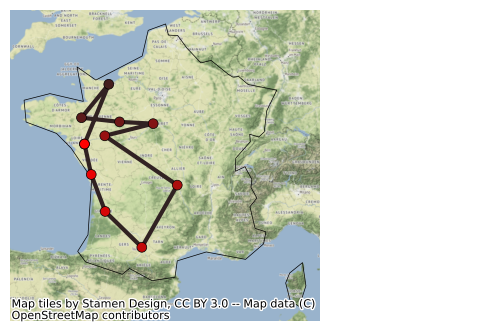

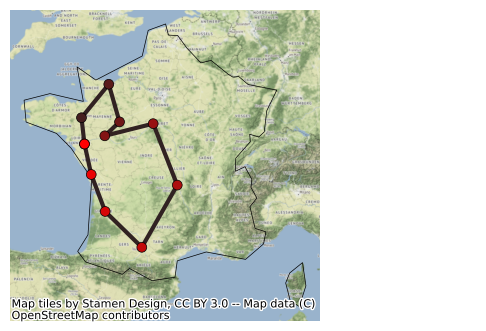

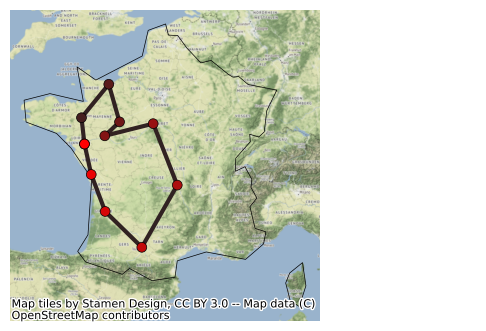

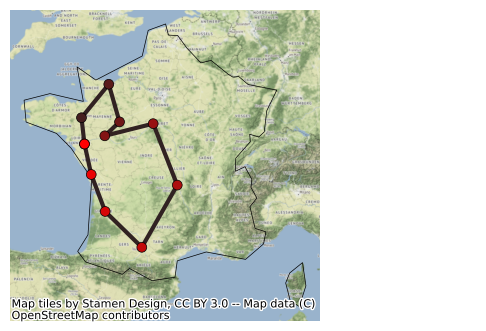

In [21]:
chemin_prof = depth_first_graph_search(music1)
chemin_largeur = breadth_first_graph_search(music1)
chemin_glouton = greedy_graph_search(music1, music1.h)
chemin_a = astar_graph_search(music1, lambda n: music1.h(n) + g(n))
afficher_carte(chemin_prof.state, music1.map)
afficher_carte(chemin_largeur.state, music1.map)
afficher_carte(chemin_glouton.state, music1.map)
afficher_carte(chemin_a.state, music1.map)

### Question 6 (bonus) : ajouter des villes dans la carte de départ et exécuter à nouveau les différents algorithmes de recherche, en affichant les résultats obtenus sur la carte de la France. Pour calculer les coordonnées gps des villes ajoutées ainsi que les distances entre ces villes et les villes déjà présentes, vous pouvez utiliser l'API d'Open Street Map (`OSMPythonTools` : https://wiki.openstreetmap.org/wiki/OSMPythonTools).

In [22]:
# test des algorithmes de recherche sur la carte tour2 (à compléter)
tour2 = Map(
    {},
    {})

music2 = MusicTourProblem(initial='Nantes', map=tour2)


### Question 7 (bonus) : comparer les différents algorithmes de recherche, en termes de nombre de noeuds générés, nombre de noeuds développés et temps de calcul (pour la carte que vous aurez créée, tour2)

In [23]:
# code à compléter